## Data loading and visualization


In [1]:
# from bioinfokit import analys, visuz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA

---
### Kuehn et al. (2024)

RNASeq analysis for EBV-immortalized B-cells from individuals with an AIOLOS E82K mutation (n=4) and healthy controls (n=3)
- *kuehn_data/GSE242931_genematrix.txt*

We are interested in EBV-immortalized B cells from healthy controls only. 

"We used reference **genome hg19**, and all files necessary for analysis were taken from the platform/resource **UCSC Genome Browser** (University of California, Santa Cruz, USA)."


In [2]:
# load kuehn et al. RNAseq data
kuehn_df = pd.read_csv('../kuehn_data/GSE242931_genematrix.txt', delimiter='\t', header=0)
kuehn_df.rename(columns = {list(kuehn_df)[0]: 'gene_ensemble'}, inplace = True)
kuehn_df.head()

,gene_ensemble,HC1_1,HC2_1,HC3_1,B.I.1_1,B.II.2_1,C.II.1_1,C.III.1_1,HC1_2,HC2_2,HC3_2,B.I.1_2,B.II.2_2,C.II.1_2,C.III.1_2
0,ENSG00000279457,17,6,8,5,12,4,6,12,10,6,17,3,12,3
1,ENSG00000225630,1134,1195,657,1223,671,2475,1992,1199,790,750,974,536,2189,794
2,ENSG00000237973,88,79,37,98,57,40,32,71,44,25,66,44,42,28
3,ENSG00000229344,25,20,23,20,2,21,9,35,21,25,29,18,15,5
4,ENSG00000248527,6605,6262,4856,6234,3118,5544,4551,8658,3438,4987,5283,3060,4876,1557


In [3]:
# remove weird spaces in column names
kuehn_df.rename(columns=lambda x: x.strip(), inplace=True)
kuehn_df.columns

Index(['gene_ensemble', 'HC1_1', 'HC2_1', 'HC3_1', 'B.I.1_1', 'B.II.2_1',
       'C.II.1_1', 'C.III.1_1', 'HC1_2', 'HC2_2', 'HC3_2', 'B.I.1_2',
       'B.II.2_2', 'C.II.1_2', 'C.III.1_2'],
      dtype='object')

In [4]:
kuehn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15870 entries, 0 to 15869
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gene_ensemble  15870 non-null  object
 1   HC1_1          15870 non-null  int64 
 2   HC2_1          15870 non-null  int64 
 3   HC3_1          15870 non-null  int64 
 4   B.I.1_1        15870 non-null  int64 
 5   B.II.2_1       15870 non-null  int64 
 6   C.II.1_1       15870 non-null  int64 
 7   C.III.1_1      15870 non-null  int64 
 8   HC1_2          15870 non-null  int64 
 9   HC2_2          15870 non-null  int64 
 10  HC3_2          15870 non-null  int64 
 11  B.I.1_2        15870 non-null  int64 
 12  B.II.2_2       15870 non-null  int64 
 13  C.II.1_2       15870 non-null  int64 
 14  C.III.1_2      15870 non-null  int64 
dtypes: int64(14), object(1)
memory usage: 1.8+ MB


---
### Converting Ensembl gene IDs into gene names

In [5]:
# helper function
def get_ensembl_ids(feature, line, remove_dot=False):

    '''
    Given a line from a genome annotation, returns the requested value.

    Arguments:  feature => the value you are interested in extracting, e.g. gene_name
                line => line from genome annotation file
                remove_dot => when true, removes '.x_y' appended to end of features

    Return:    value of the feature you extracted
    '''

    # some files have e.g. .1_1 appended to ensemble gene id
    if remove_dot:
        return line.split(feature)[1].split('"')[1].split('.')[0]

    return line.split(feature)[1].split('"')[1]

In [6]:
# load ucsc annotations
with open('../annotations/ensemblToGeneName.txt') as file: # contains ensembl transcript ids and gene names
    ensemblToGeneName = list(file)

with open('../annotations/hg19.ensGene.gtf') as file: # contains ensembl transcript ids and gene ids
    ensGene = list(file)

with open('../annotations/ensemblSource.txt') as file:
    ensemblSource = list(file)

# load gencode comprehensive genome annotation
with open('../annotations/gencode.v46lift37.annotation.gtf') as file: # gencode GrCh37 (hg19) comprehensive genome annotation
    gencode = list(file)[5:] # remove metadata

In [7]:
# extract ensembl transcript ids and corresponding gene ids
# NOTE: wanted to do it in this order (transcript_id, gene_id) because transcript_id => gene_id is a surjection
#   however, it doesn't actually matter because my data is in gene_ids anyways
enst_to_ensg = dict(map(lambda x: (get_ensembl_ids('transcript_id', x), get_ensembl_ids('gene_id', x)), ensGene))

# extract ensembl transcript ids and corresponding gene names
enst_to_gene = dict(map(lambda x: x.strip('\n').split('\t'), ensemblToGeneName))

# extract ensembl transcript ids and corresponding gene types
ucsc_enst_to_type = dict(map(lambda x: x.strip('\n').split('\t'), ensemblSource))

# check same length (though they don't need to be)
len(enst_to_ensg) == len(enst_to_gene) == len(ucsc_enst_to_type)

True

In [8]:
# extract ensemble gene ids and corresponding gene types
gencode_ensg_to_type = dict(
    map(lambda x: (get_ensembl_ids('gene_id', x, remove_dot=True), get_ensembl_ids('gene_type', x, remove_dot=True)), 
        gencode)
        )

In [9]:
# combine enst_to_ensg and enst_to_gene to create dictionary relating gene_id and gene_name
keys = list(enst_to_ensg.values())
values = [enst_to_gene[enst] for enst in enst_to_ensg]
ensg_to_gene = dict(zip(keys, values))
ensg_to_gene

# combine enst_to_ensg and enst_to_type to create dictionary relating gene_id and gene_name
keys = list(enst_to_ensg.values())
values = [ucsc_enst_to_type[enst] for enst in enst_to_ensg]
ucsc_ensg_to_type = dict(zip(keys, values))
ucsc_ensg_to_type

{'ENSG00000223972': 'transcribed_unprocessed_pseudogene',
 'ENSG00000227232': 'unprocessed_pseudogene',
 'ENSG00000243485': 'miRNA',
 'ENSG00000237613': 'lincRNA',
 'ENSG00000268020': 'unprocessed_pseudogene',
 'ENSG00000240361': 'unprocessed_pseudogene',
 'ENSG00000186092': 'protein_coding',
 'ENSG00000238009': 'lincRNA',
 'ENSG00000239945': 'lincRNA',
 'ENSG00000233750': 'processed_pseudogene',
 'ENSG00000237683': 'protein_coding',
 'ENSG00000268903': 'processed_pseudogene',
 'ENSG00000269981': 'processed_pseudogene',
 'ENSG00000239906': 'antisense',
 'ENSG00000241860': 'lincRNA',
 'ENSG00000222623': 'snRNA',
 'ENSG00000241599': 'lincRNA',
 'ENSG00000228463': 'lincRNA',
 'ENSG00000241670': 'processed_pseudogene',
 'ENSG00000237094': 'lincRNA',
 'ENSG00000250575': 'unprocessed_pseudogene',
 'ENSG00000233653': 'processed_pseudogene',
 'ENSG00000224813': 'transcribed_unprocessed_pseudogene',
 'ENSG00000235249': 'protein_coding',
 'ENSG00000269732': 'processed_pseudogene',
 'ENSG00000256

In [10]:
# comparing and contrasting the dictionaries
print('gencode ensg_to_type length: ', len(gencode_ensg_to_type))
print('ucsc ensg_to_type length: ', len(ucsc_ensg_to_type))

# checking the overlap of the two above dictionaries
common_keys = set(gencode_ensg_to_type.keys()) & set(ucsc_ensg_to_type.keys()) # length 55439
new_dict1 = {key: gencode_ensg_to_type[key] for key in common_keys}
new_dict2 = {key: ucsc_ensg_to_type[key] for key in common_keys}
 
# compare values of corresponding keys
count = 0
for key in new_dict1.keys():
    if new_dict1[key] != new_dict2[key]:
        # print(new_dict1[key], ' ', new_dict2[key])
        count +=1

print('---')
print('number of shared ENSG keys: ', len(common_keys))
print('differing values for same key: ', count, '/', len(common_keys))
print('---')
print('non-null gene_names in kuehn_df after mapping gencode dict: ', 
      kuehn_df['gene_ensemble'].map(gencode_ensg_to_type).notnull().sum(),
      '/', len(kuehn_df))
print('non-null gene_names in kuehn_df after mapping ucsc dict: ', 
      kuehn_df['gene_ensemble'].map(ucsc_ensg_to_type).notnull().sum(),
      '/', len(kuehn_df))

gencode ensg_to_type length:  64854
ucsc ensg_to_type length:  60234
---
number of shared ENSG keys:  55439
differing values for same key:  24989 / 55439
---
non-null gene_names in kuehn_df after mapping gencode dict:  15704 / 15870
non-null gene_names in kuehn_df after mapping ucsc dict:  15309 / 15870


In [11]:
kuehn_df.insert(1, 'gene_name', kuehn_df['gene_ensemble'].map(ensg_to_gene))

# used gencode_ensg_to_type because more coverage of entries. also, 
#   if use ucsc_ensg_to_type, all missing gene_names will also have missing gene_types
kuehn_df.insert(2, 'gene_type', kuehn_df['gene_ensemble'].map(gencode_ensg_to_type)) 
kuehn_df

,gene_ensemble,gene_name,gene_type,HC1_1,HC2_1,HC3_1,B.I.1_1,B.II.2_1,C.II.1_1,C.III.1_1,HC1_2,HC2_2,HC3_2,B.I.1_2,B.II.2_2,C.II.1_2,C.III.1_2
0,ENSG00000279457,NaN,NaN,17,6,8,5,12,4,6,12,10,6,17,3,12,3
1,ENSG00000225630,MTND2P28,unprocessed_pseudogene,1134,1195,657,1223,671,2475,1992,1199,790,750,974,536,2189,794
2,ENSG00000237973,hsa-mir-6723,unprocessed_pseudogene,88,79,37,98,57,40,32,71,44,25,66,44,42,28
3,ENSG00000229344,RP5-857K21.7,unprocessed_pseudogene,25,20,23,20,2,21,9,35,21,25,29,18,15,5
4,ENSG00000248527,MTATP6P1,unprocessed_pseudogene,6605,6262,4856,6234,3118,5544,4551,8658,3438,4987,5283,3060,4876,1557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15865,ENSG00000276345,NaN,NaN,0,0,64,54,0,0,2,0,1,69,38,1,2,0
15866,ENSG00000277856,NaN,NaN,0,0,0,14,11,0,8,1,0,1,6,11,0,6
15867,ENSG00000275063,NaN,NaN,1,2,152,7,2,5,421,0,0,137,1,1,1,150
15868,ENSG00000271254,NaN,NaN,6,12,15,15,4,5,32,7,4,14,6,10,11,3


In [12]:
missing_genes = kuehn_df['gene_type'][kuehn_df['gene_name'].isnull()]
print('# of missing genes: ', len(missing_genes))

# of missing genes:  561


In [13]:
# the gene_types that I am able to identify for entries with missing gene_name for their
#   given gene_ensemble ID
missing_genes[missing_genes.notnull()].value_counts()

gene_type
lncRNA                                184
protein_coding                        144
TEC                                    86
transcribed_unprocessed_pseudogene     19
processed_pseudogene                   14
unprocessed_pseudogene                  7
artifact                                6
transcribed_processed_pseudogene        5
IG_V_gene                               4
transcribed_unitary_pseudogene          1
TR_C_gene                               1
IG_V_pseudogene                         1
snoRNA                                  1
Name: count, dtype: int64

#### ^ gene / transcript biotype descriptions for gencode genes found [here](https://www.gencodegenes.org/pages/biotypes.html)

---
### Removing the genes we do not care about
TODO: for now, just remove the nones. but come back to look at those later!

In [14]:
kuehn_df = kuehn_df[kuehn_df['gene_name'].notnull()]
kuehn_df

,gene_ensemble,gene_name,gene_type,HC1_1,HC2_1,HC3_1,B.I.1_1,B.II.2_1,C.II.1_1,C.III.1_1,HC1_2,HC2_2,HC3_2,B.I.1_2,B.II.2_2,C.II.1_2,C.III.1_2
1,ENSG00000225630,MTND2P28,unprocessed_pseudogene,1134,1195,657,1223,671,2475,1992,1199,790,750,974,536,2189,794
2,ENSG00000237973,hsa-mir-6723,unprocessed_pseudogene,88,79,37,98,57,40,32,71,44,25,66,44,42,28
3,ENSG00000229344,RP5-857K21.7,unprocessed_pseudogene,25,20,23,20,2,21,9,35,21,25,29,18,15,5
4,ENSG00000248527,MTATP6P1,unprocessed_pseudogene,6605,6262,4856,6234,3118,5544,4551,8658,3438,4987,5283,3060,4876,1557
5,ENSG00000198744,RP5-857K21.11,unprocessed_pseudogene,34,21,10,22,19,16,5,22,3,5,9,18,13,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15852,ENSG00000198695,MT-ND6,protein_coding,1408,1838,626,1806,947,1132,893,1489,951,702,1676,754,1165,363
15853,ENSG00000210194,MT-TE,Mt_tRNA,121,36,17,21,82,6,8,36,6,18,30,13,5,34
15854,ENSG00000198727,MT-CYB,protein_coding,30727,38866,18227,37262,16825,26548,21676,39375,23277,18759,28383,14665,24045,8243
15855,ENSG00000210195,MT-TT,Mt_tRNA,267,239,131,229,170,53,46,226,55,124,167,95,47,57


---
### PCA on the data to see if we can get a separation between conditions

In [15]:
# transpose df to get samples in rows and genes (features) in columns
numeric_T = kuehn_df.select_dtypes(include='number').T
numeric_T.columns = kuehn_df['gene_name']
numeric_T.head()

gene_name,MTND2P28,hsa-mir-6723,RP5-857K21.7,MTATP6P1,RP5-857K21.11,RP11-206L10.2,RP11-206L10.9,RP11-206L10.8,LINC01128,LINC00115,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
HC1_1,1134,88,25,6605,34,36,19,13,122,18,...,70603,382,159,70,65834,1408,121,30727,267,146
HC2_1,1195,79,20,6262,21,70,10,16,170,1,...,88882,150,66,32,94145,1838,36,38866,239,93
HC3_1,657,37,23,4856,10,26,19,9,90,7,...,57735,80,17,27,51021,626,17,18227,131,47
B.I.1_1,1223,98,20,6234,22,61,19,23,167,19,...,85596,74,43,27,81184,1806,21,37262,229,98
B.II.2_1,671,57,2,3118,19,35,13,20,80,11,...,45582,238,248,21,44593,947,82,16825,170,106


In [16]:
# standardize features (scale to have mean = 0 and stddev = 1)
scaler = preprocessing.StandardScaler()
scaler.set_output(transform='pandas')
df_scaled = scaler.fit_transform(numeric_T)
df_scaled.describe()

,MTND2P28,hsa-mir-6723,RP5-857K21.7,MTATP6P1,RP5-857K21.11,RP11-206L10.2,RP11-206L10.9,RP11-206L10.8,LINC01128,LINC00115,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
count,1.400000e+01,1.400000e+01,1.400000e+01,1.400000e+01,1.400000e+01,14.000000,1.400000e+01,1.400000e+01,1.400000e+01,1.400000e+01,...,1.400000e+01,1.400000e+01,1.400000e+01,1.400000e+01,1.400000e+01,1.400000e+01,1.400000e+01,1.400000e+01,14.000000,1.400000e+01
mean,-1.268826e-16,-1.110223e-16,4.758099e-17,1.427430e-16,-9.516197e-17,0.000000,4.758099e-17,-6.344132e-17,-1.110223e-16,1.348128e-16,...,1.586033e-16,2.379049e-17,-4.758099e-17,1.189525e-17,-1.586033e-16,1.586033e-17,2.874685e-17,3.172066e-17,0.000000,-1.149874e-16
std,1.037749e+00,1.037749e+00,1.037749e+00,1.037749e+00,1.037749e+00,1.037749,1.037749e+00,1.037749e+00,1.037749e+00,1.037749e+00,...,1.037749e+00,1.037749e+00,1.037749e+00,1.037749e+00,1.037749e+00,1.037749e+00,1.037749e+00,1.037749e+00,1.037749,1.037749e+00
min,-1.103076e+00,-1.282119e+00,-1.974122e+00,-1.966150e+00,-1.335375e+00,-1.863381,-1.403161e+00,-1.663151e+00,-1.643365e+00,-1.658076e+00,...,-2.205759e+00,-1.001029e+00,-8.847461e-01,-1.315955e+00,-2.233670e+00,-1.718690e+00,-8.197891e-01,-1.824763e+00,-1.162372,-1.258332e+00
25%,-7.218919e-01,-7.114002e-01,-3.907117e-01,-7.077449e-01,-9.848391e-01,-0.492214,-7.068160e-01,-6.162033e-01,-4.328166e-01,-7.133582e-01,...,-3.725315e-01,-6.478331e-01,-6.437900e-01,-5.538372e-01,-5.582558e-01,-7.584115e-01,-6.854160e-01,-7.082075e-01,-1.039872,-7.235937e-01
50%,-2.215876e-01,-4.316361e-01,1.562847e-01,4.995406e-04,8.346094e-03,-0.175791,-1.570702e-01,-1.555465e-01,-2.656137e-01,-2.185061e-01,...,-1.410607e-01,-3.204178e-01,-3.637600e-01,-2.887527e-01,1.630107e-01,-1.883342e-01,-3.613396e-01,-1.231665e-01,-0.111448,-2.928326e-01
75%,5.579195e-02,7.209921e-01,6.169132e-01,6.590606e-01,7.094180e-01,0.439477,7.591727e-01,7.657672e-01,3.764453e-01,1.413863e-01,...,4.163801e-01,3.395692e-01,-7.396142e-02,1.420095e-01,4.446623e-01,7.753278e-01,1.445358e-01,5.919939e-01,0.978161,7.246547e-01
max,2.196550e+00,1.985526e+00,1.826063e+00,2.172294e+00,2.286830e+00,2.074330,2.408410e+00,1.687081e+00,1.673940e+00,2.120795e+00,...,1.777813e+00,2.824832e+00,2.345368e+00,2.991668e+00,1.770200e+00,1.608171e+00,2.847807e+00,1.611097e+00,1.687374,2.187757e+00


In [17]:
# TODO plot better. add labels. see if can output as df
n_comp = 5
pca = PCA(n_components=n_comp)
pca.set_output(transform='pandas')
scores = pca.fit_transform(df_scaled)
scores.columns = ['PC' + str(i + 1) for i in range(n_comp)]
scores

,PC1,PC2,PC3,PC4,PC5
HC1_1,196.584308,-35.998346,-36.399623,-22.853499,0.201904
HC2_1,69.233474,20.063064,107.962979,-16.551061,-24.974623
HC3_1,-14.872202,-56.023478,5.929703,59.048541,-13.430065
B.I.1_1,37.914550,100.213047,-12.344547,35.829483,3.286421
B.II.2_1,-63.434972,18.853222,-26.961703,-20.337389,-16.064442
C.II.1_1,-42.983227,-4.867297,8.159756,-4.636925,55.761989
C.III.1_1,16.910673,34.483008,-32.619009,-29.087186,-28.649704
HC1_2,182.738251,-33.500832,-16.672945,-3.245857,5.386621
HC2_2,-48.948330,-16.310101,41.625989,-25.395937,3.906713
HC3_2,-38.115597,-57.714235,2.934682,49.127188,-12.169633


In [18]:
cond = [''] * scores.shape[0]
for idx, label in enumerate(scores.index):
    if 'HC' in label:
        cond[idx] = 'HC'
    elif 'B' in label:
        cond[idx] = 'B'
    else:
        cond[idx] = 'C'
    
scores['labels'] = cond
scores

,PC1,PC2,PC3,PC4,PC5,labels
HC1_1,196.584308,-35.998346,-36.399623,-22.853499,0.201904,HC
HC2_1,69.233474,20.063064,107.962979,-16.551061,-24.974623,HC
HC3_1,-14.872202,-56.023478,5.929703,59.048541,-13.430065,HC
B.I.1_1,37.914550,100.213047,-12.344547,35.829483,3.286421,B
B.II.2_1,-63.434972,18.853222,-26.961703,-20.337389,-16.064442,B
C.II.1_1,-42.983227,-4.867297,8.159756,-4.636925,55.761989,C
C.III.1_1,16.910673,34.483008,-32.619009,-29.087186,-28.649704,C
HC1_2,182.738251,-33.500832,-16.672945,-3.245857,5.386621,HC
HC2_2,-48.948330,-16.310101,41.625989,-25.395937,3.906713,HC
HC3_2,-38.115597,-57.714235,2.934682,49.127188,-12.169633,HC


In [27]:
# TODO: issue with outputting as dataframe i guess. i want scree
scores.explained_variance_ratio

AttributeError: 'DataFrame' object has no attribute 'explained_variance_ratio'

<Axes: xlabel='PC1', ylabel='PC2'>

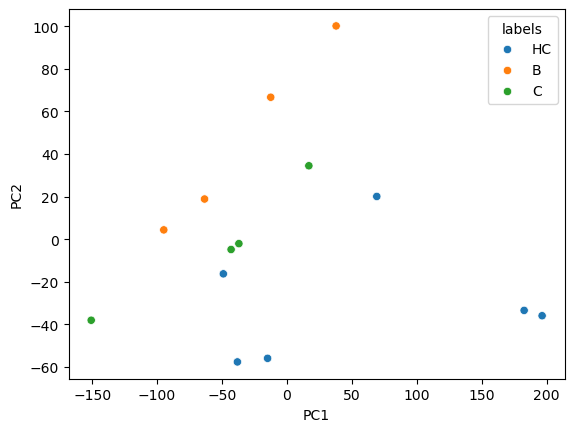

In [19]:
sns.scatterplot(data=scores, x='PC1', y='PC2', hue='labels')

---
### Plotting differential gene expression heatmap

In [20]:
kuehn_df.mean(numeric_only=True, axis=0)

HC1_1        1658.370762
HC2_1        1266.899275
HC3_1         931.033967
B.I.1_1      1158.363642
B.II.2_1      764.612189
C.II.1_1      807.492325
C.III.1_1    1028.972500
HC1_2        1589.922137
HC2_2         776.485858
HC3_2         843.779803
B.I.1_2       964.438762
B.II.2_2      631.168398
C.II.1_2      829.769613
C.III.1_2     413.008034
dtype: float64

In [21]:
# ddof = 0 for population stddev, ddof = 1 for sample stddev
kuehn_df.std(numeric_only=True, axis=0, ddof=1) 

HC1_1        7490.257376
HC2_1        5641.916230
HC3_1        4106.656490
B.I.1_1      5398.647187
B.II.2_1     4037.636068
C.II.1_1     3412.541319
C.III.1_1    4083.271228
HC1_2        6467.719811
HC2_2        3437.683081
HC3_2        3711.930550
B.I.1_2      4642.084018
B.II.2_2     2772.768124
C.II.1_2     3460.255412
C.III.1_2    1958.613773
dtype: float64

In [22]:
# this is what we are hoping to get information from, since combining datasets
# zscore across genes per sample with ddof = 1 default for sp.stats.zscore
zscored_df = kuehn_df.loc[:, 'HC1_1':].apply(sp.stats.zscore, axis=0, ddof=1)
zscored_df.insert(0, 'gene_name', kuehn_df['gene_name'])
zscored_df

,gene_name,HC1_1,HC2_1,HC3_1,B.I.1_1,B.II.2_1,C.II.1_1,C.III.1_1,HC1_2,HC2_2,HC3_2,B.I.1_2,B.II.2_2,C.II.1_2,C.III.1_2
1,MTND2P28,-0.070007,-0.012744,-0.066729,0.011973,-0.023185,0.488641,0.235847,-0.060442,0.003931,-0.025264,0.002060,-0.034323,0.392812,0.194521
2,hsa-mir-6723,-0.209655,-0.210549,-0.217704,-0.196413,-0.175254,-0.224903,-0.244160,-0.234847,-0.213075,-0.220581,-0.193542,-0.211763,-0.227662,-0.196572
3,RP5-857K21.7,-0.218066,-0.221006,-0.221113,-0.210861,-0.188876,-0.230471,-0.249793,-0.240413,-0.219766,-0.220581,-0.201513,-0.221139,-0.235465,-0.208315
4,MTATP6P1,0.660408,0.885355,0.955757,0.940168,0.582863,1.387971,0.862550,1.092824,0.774217,1.116190,0.930307,0.875959,1.169344,0.584082
5,RP5-857K21.11,-0.216864,-0.220829,-0.224278,-0.210490,-0.184666,-0.231936,-0.250773,-0.242423,-0.225002,-0.225969,-0.205821,-0.221139,-0.236043,-0.208315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15852,MT-ND6,-0.033426,0.101225,-0.074278,0.119963,0.045172,0.095093,-0.033300,-0.015604,0.050765,-0.038196,0.153285,0.044299,0.096880,-0.025532
15853,MT-TE,-0.205249,-0.218170,-0.222574,-0.210676,-0.169062,-0.234867,-0.250038,-0.240258,-0.224129,-0.222466,-0.201297,-0.222943,-0.238355,-0.193508
15854,MT-CYB,3.880859,6.664243,4.211690,6.687534,3.977671,7.542915,5.056492,5.842102,6.545256,4.826389,5.906520,5.061307,6.709109,3.997721
15855,MT-TT,-0.185757,-0.182190,-0.194814,-0.172148,-0.147267,-0.221094,-0.240732,-0.210881,-0.209876,-0.193910,-0.171785,-0.193369,-0.226217,-0.181765


In [23]:
# zscored across genes per sample
# sns.set_context('paper', font_scale = 0.5) 
# sns.clustermap(zscored_df.loc[:, 'HC1_1':], xticklabels=zscored_df.columns[1:], yticklabels=zscored_df['gene_name'])

In [24]:
# zscore across samples per gene with ddof=1 default for sp.stats.zscore
zscored_df_1 = kuehn_df.loc[:, 'HC1_1':].apply(sp.stats.zscore, axis=1, ddof=1)
zscored_df_1.insert(0, 'gene_name', kuehn_df['gene_name'])
zscored_df_1

,gene_name,HC1_1,HC2_1,HC3_1,B.I.1_1,B.II.2_1,C.II.1_1,C.III.1_1,HC1_2,HC2_2,HC3_2,B.I.1_2,B.II.2_2,C.II.1_2,C.III.1_2
1,MTND2P28,-0.082342,0.017687,-0.864533,0.063601,-0.841576,2.116648,1.324618,0.024246,-0.646438,-0.712031,-0.344712,-1.062951,1.647661,-0.639879
2,hsa-mir-6723,1.481961,1.093755,-0.717873,1.913301,0.144807,-0.588471,-0.933543,0.748683,-0.415935,-1.235481,0.533013,-0.415935,-0.502203,-1.106079
3,RP5-857K21.7,0.649957,0.095116,0.428020,0.095116,-1.902312,0.206084,-1.125534,1.759638,0.206084,0.649957,1.093829,-0.126821,-0.459725,-1.569407
4,MTATP6P1,0.940315,0.747687,-0.041919,0.731962,-1.017976,0.344460,-0.213207,2.093275,-0.838265,0.031650,0.197883,-1.050549,-0.030687,-1.894630
5,RP5-857K21.11,2.203644,0.739910,-0.498635,0.852505,0.514720,0.176935,-1.061610,0.852505,-1.286800,-1.061610,-0.611230,0.402125,-0.160850,-1.061610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15852,MT-ND6,0.615087,1.549672,-1.084553,1.480122,-0.386875,0.015214,-0.504241,0.791137,-0.378181,-0.919371,1.197573,-0.806351,0.086938,-1.656171
15853,MT-TE,2.744216,0.154512,-0.424363,-0.302495,1.555999,-0.759501,-0.698567,0.154512,-0.759501,-0.393896,-0.028291,-0.546232,-0.789969,0.093578
15854,MT-CYB,0.632780,1.498360,-0.696590,1.327776,-0.845693,0.188345,-0.329790,1.552492,-0.159524,-0.640012,0.383497,-1.075408,-0.077848,-1.758385
15855,MT-TT,1.625994,1.278074,-0.063904,1.153817,0.420699,-1.033110,-1.120090,1.116540,-1.008258,-0.150884,0.383422,-0.511230,-1.107664,-0.983407


In [25]:
# zscored across samples per gene
# sns.set_context('paper', font_scale = 0.5) 
# sns.clustermap(zscored_df_1.loc[:, 'HC1_1':], 
#                xticklabels=zscored_df_1.columns[1:], 
#                yticklabels=zscored_df_1['gene_name'],
#                cmap='coolwarm')